In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fragmenter import chemi
from openeye import oechem
import oenotebook as oenb
import json
import numpy as np
import glob
import cmiles
import os
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sbn
import pandas as pd
import matplotlib.image as mpimg
import copy

In [11]:
# maximum mean discrepancy with different kernels

def mmd_x_xsqred(x, y):
    
    y_arr = np.asarray(y)
    y_squared = y_arr*y_arr
    x_arr = np.asarray(x)
    x_squared = np.square(x_arr)

    E_x = np.mean(x_arr)
    E_y = np.mean(y_arr)

    E_x_squared = np.mean(x_squared)
    E_y_squared = np.mean(y_squared)

    mmd2 = (E_x - E_y)**2 + (E_x_squared - E_y_squared)**2
    return mmd2

def mmd_linear(x, y):
    y_arr = np.asarray(y)
    x_arr = np.asarray(x)

    E_x = np.mean(x_arr)
    E_y = np.mean(y_arr)

    mmd2 = (E_x - E_y)**2 
    return mmd2

def mmd_rbf(x, y, sigma=0, biased=True):
    gamma = 1 / (2*sigma**2)
    x_arr = np.asarray(x)
    x_arr = x_arr[:, np.newaxis]
    y_arr = np.asarray(y)
    y_arr = y_arr[:, np.newaxis]
    
    # all arrays are 1D 
    xx = np.dot(x_arr, x_arr.transpose())
    yy = np.dot(y_arr, y_arr.transpose())
    xy = np.dot(x_arr, y_arr.transpose())
    
    x_sqnorms = np.diag(xx)
    y_sqnorms = np.diag(yy)
    
    k_xy = np.exp(-gamma * (
                    -2 * xy + x_sqnorms[:, np.newaxis] + y_sqnorms[np.newaxis, :]))
    k_xx = np.exp(-gamma * (
                    -2 * xx + x_sqnorms[:, np.newaxis] + x_sqnorms[np.newaxis, :]))
    k_yy = np.exp(-gamma * (
                    -2 * yy + y_sqnorms[:, np.newaxis] + y_sqnorms[np.newaxis, :]))
    if biased:
        mmd2 = k_xx.mean() + k_yy.mean() - 2*k_xy.mean()
    else:
        m = k_xx.shape[0]
        n = k_yy.shape[0]

        mmd2 = ((k_xx.sum() - m) / (m * (m - 1))
              + (k_yy.sum() - n) / (n * (n - 1))
              - 2 * k_xy.mean())
    return mmd2

In [27]:
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True, filename=None, title=None, colors=None):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for i, pair in enumerate(sorted_list[1:]):
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
                
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
                
    
    '''Plotting process'''
    plt.figure()
    plt.scatter(Xs,Ys,edgecolors='black', c=colors)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y, color='black', linewidth=1)
    plt.plot(pf_X, pf_Y, '.', color='black', markersize=2.5)
    plt.xlabel("MMD score")
    plt.ylabel("Molecular size")
    plt.title(title)
    #plt.show()
    if filename:
        plt.savefig(filename)
    plt.close()
    return pareto_front

def fragment_wbo_ridge_plot(data, filename, sorted_keys):
    """
    data: dict of dict
        bond: frags: [wbos]
    colors: numpy array
        output from matplotlib color map
    sorted_keys: dict
        bond: sorted_frags
    filname: str
        filename 
    """
    with PdfPages(filename) as pdf:
        for bond in data:
            n = len(data[bond])
            fig, axes = plt.subplots(n, 1)
            fig.dpi = 400
            x_min = 3
            x_max = 0
            for f in data[bond]:
                wbo = data[bond][f]['individual_conf']
                if min(wbo) < x_min:
                    x_min = min(wbo)
                if max(wbo) > x_max:
                    x_max = max(wbo)
            
            norm = plt.Normalize(min(sorted_keys[bond]['rbf_mmd']), max(sorted_keys[bond]['rbf_mmd']))
            colors = plt.cm.viridis_r(norm(sorted_keys[bond]['rbf_mmd'])) 
            for i, frag in enumerate(sorted_keys[bond]['sorted_frags']):
                wbo = data[bond][frag]['individual_conf']

                wbo_s = data[bond][frag]['ensamble']
                ax = plt.subplot(n, 1, i+1)
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.patch.set_facecolor('none')
                if frag == 'parent':
                    sbn.kdeplot(wbo, shade= True, color='red', alpha=1.0)
                    sbn.kdeplot(wbo, lw=2, color='black')
                #elif frag.split('_')[-1] == 'term':
                #    sbn.kdeplot(wbo, shade= True, color='green', alpha=0.8)
                #else:
                    #sbn.kdeplot(wbo, shade= True, alpha=0.8)

                else:
                    sbn.kdeplot(wbo, shade=True, color=colors[i], alpha=0.7)
                    sbn.kdeplot(wbo, lw=0.8, color='black')
                #sbn.distplot(wbo, hist=False, rug=True, kde=False, color='black')

                #plt.axvline(x=wbo_s, ymin=0, ymax=1, color='black', linewidth=0.5)
                #if len(wbo) < 2:
                #    plt.axvline(x=wbo_s, ymin=0, ymax=1, color=colors[i], linewidth=2.0, alpha=0.8)
                #plt.axvline(x=wbo_s, ymin=0, ymax=1, color='black', linewidth=0.5)
                plt.xlim(x_min-0.1, x_max+0.1)
                plt.yticks([])
                #ax.set_yticklabels(bond_order_std_rot_bonds_opt['Imatinib']['bonds'], fontsize=6, rotation=0)
                #ax.yaxis.grid(False)
                ax.yaxis.set_label_coords(-0.05, 0)
                #plt.ylabel(i, rotation=0, size=8)
                if i != n-1:
                    plt.xticks([])
                else:
                    plt.xlabel('Bond order')
                if i == 0:
                    #plt.legend(prop={'size': 10}, bbox_to_anchor=(1.35, 1))
                    plt.title(bond)
            overlap=0.5
            h_pad = 5 + (- 5*(1 + overlap))
            fig.tight_layout(h_pad=h_pad)
            pdf.savefig(bbox_inches='tight')
            plt.close()


In [3]:
with open('../filter/filtered_kinase_inhibitors.json', 'r') as f:
    kinase_inhibitors = json.load(f)
names = list(kinase_inhibitors.keys())

In [6]:
names.index('Dabrafenib')

8

In [7]:
name = names[8]
with open('../fragment_bond_orders/kinase_inhibitors/{}/{}_oe_wbo_by_bond_all.json'.format(name, name)) as f:
    wbo = json.load(f)
with open('../fragment/kinase_inhitibors/{}_fragments.json'.format(name), 'r') as f:
    fragments = json.load(f)

In [8]:
# deserialze
wbo_des = {}
for bond in wbo:
    key = (bond.split('[')[-1].split(']')[0].split(','))
    key = (int(key[0]), int(key[-1]))
    wbo_des[key] = wbo[bond]

In [9]:
# remove parent with suffixed
for bond in wbo:
    if 'parent_term' in wbo[bond]:
        key = (bond.split('[')[-1].split(']')[0].split(','))
        key = (int(key[0]), int(key[-1]))
        wbo_des[key]['parent'] = wbo[bond]['parent_term']
        wbo_des[key].pop('parent_term')
    elif 'parent_halogen' in wbo[bond]:
        key = (bond.split('[')[-1].split(']')[0].split(','))
        key = (int(key[0]), int(key[-1]))
        wbo_des[key]['parent'] = wbo[bond]['parent_halogen']
        wbo_des[key].pop('parent_halogen')
    elif 'parent_double' in wbo[bond]:
        key = (bond.split('[')[-1].split(']')[0].split(','))
        key = (int(key[0]), int(key[-1]))
        wbo_des[key]['parent'] = wbo[bond]['parent_double']
        wbo_des[key].pop('parent_double')

In [12]:
# Get a ranking for all fragments
for bond in wbo_des:
    if 'parent' in wbo_des[bond]:
        x = wbo_des[bond]['parent']['individual_conf']
    for frag in wbo_des[bond]:
        y = wbo_des[bond][frag]['individual_conf']
        linear = mmd_linear(x, y)
        squared = mmd_x_xsqred(x, y)
        rbf = mmd_rbf(x, y, sigma=0.01)
        wbo_des[bond][frag]['linear_mmd'] = linear
        wbo_des[bond][frag]['squared_mmd'] = squared
        wbo_des[bond][frag]['rbf_mmd'] = rbf

In [13]:
# Generate Pareto frontier depict the fragments on the front
# First sort frags by OE WBO
sorted_frags = {}
for bond in wbo_des:
    sorted_frags[bond] = {}
    list_1 = []
    list_2 = []
    for frag in wbo_des[bond]:
        # Get molecular size
        list_1.append(frag)
        list_2.append(wbo_des[bond][frag]['ensamble'])
    sorted_f = [x for _, x in sorted(zip(list_2, list_1))]
    sorted_frags[bond]['sorted_frags'] = sorted_f
    sorted_frags[bond]['heavy_atoms'] = []
    sorted_frags[bond]['rbf_mmd'] = []
    for frag in sorted_frags[bond]['sorted_frags']:
        if frag == 'parent':
            oemol = cmiles.utils.load_molecule(kinase_inhibitors[name]['canonical_isomeric_smiles'])
        else:
            smiles = frag.split('_')[0]
            oemol = cmiles.utils.load_molecule(smiles)
        count = oechem.OECount(oemol, oechem.OEIsHeavy())
        sorted_frags[bond]['heavy_atoms'].append(count)
        sorted_frags[bond]['rbf_mmd'].append(wbo_des[bond][frag]['rbf_mmd'])  

In [45]:
# plot parato front and generate images for molecules on fronteir
for bond in wbo_de:
    x = sorted_frags[bond]['rbf_mmd']
    y = sorted_frags[bond]['heavy_atoms']
    try:
        os.mkdir('kinase_inhibitors/{}'.format(name))
    except FileExistsError:
        pass
    try:
        dir_name_1 = 'kinase_inhibitors/{}/bond_{}_{}'.format(name, bond[0], bond[1])
        os.mkdir(dir_name_1)
    except FileExistsError:
         pass
    try:
        dir_name_2 = dir_name_1 + '/front'
        os.mkdir(dir_name_2)
    except FileExistsError:
        pass
    norm = plt.Normalize(min(x), max(x))
    colors = plt.cm.viridis_r(norm(x)) 
    front = plot_pareto_frontier(x, y, maxX=False, maxY=False, title=bond, colors=colors,
                                 filename='{}/{}_bond_{}_{}_front_2.pdf'.format(dir_name_1, name, bond[0], bond[1]))
    
    
    # find the fragments on the front
    #front_tuples = [tuple(i) for i in front]
    #idx = []
    #zipped = list(zip(sorted_frags[bond]['rbf_mmd'], sorted_frags[bond]['heavy_atoms']))
    #for i, j in enumerate(front_tuples):
    #    if j in zipped:
    #        idx.append(zipped.index(j))
    #oemols = []
    bond = (35, 14)
    for i, smiles in enumerate(sorted_frag[(35, 14)]['sorted_frags']):
        #smiles = sorted_frags[bond]['sorted_frags'][i].split('_')[0]
        if smiles == 'parent':
            map_to_parent = kinase_inhibitors[name]['canonical_isomeric_explicit_hydrogen_mapped_smiles']
        else:   
            map_to_parent = fragments[smiles]['provenance']['routine']['enumerate_fragments']['map_to_parent']
        oemol = cmiles.utils.load_molecule(map_to_parent)
        score = sorted_frag[bond]['rbf_mmd'][i]
        title = 'idx_{}_mmd_{}'.format(i, score)
        oemol.SetTitle(title)
        a1 = oemol.GetAtom(oechem.OEHasMapIdx(bond[0]))
        a2 = oemol.GetAtom(oechem.OEHasMapIdx(bond[1]))
        b = oemol.GetBond(a1, a2)
        frag = sorted_frags[bond]['sorted_frags'][i]
        wbo = wbo_de[bond][frag]['ensamble']
        tag = oechem.OEGetTag('WibergBondOrder')
        b.SetData(tag, wbo)
        oemols.append(oemol)
        ha_count = sorted_frags[bond]['heavy_atoms'][i]
        fname = '{}/atoms_{}_frag_{}_bond_{}_{}_2.pdf'.format(dir_name_2, ha_count, i, bond[0], bond[1])
        chemi.highlight_bond_by_map_idx(map_to_parent, [bond], fname=fname)
    chemi.to_pdf(oemols, oname='{}/front_frags_bond_{}_{}_2.pdf'.format(dir_name_2, bond[0], bond[1]), 
                 bond_map_idx=bond, bo=True)
        
        
        
    
    

In [23]:
wbo_de = {(35, 14): wbo_des[(35, 14)]}

In [19]:
sorted_frags[(35, 14)]
sorted_frag = {(35, 14): sorted_frags[(35, 14)]}

In [28]:
# ridge plot
fragment_wbo_ridge_plot(data=wbo_de, sorted_keys=sorted_frag, 
                        filename='kinase_inhibitors/{}/{}_ridge_plot_2.pdf'.format(name, name))

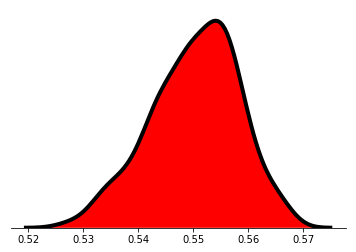

In [41]:
wbo = wbo_de[(35, 14)]['parent']['individual_conf']
ax = plt.subplot()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
sbn.kdeplot(wbo, shade= True, color='red', alpha=1.0)
sbn.kdeplot(wbo, lw=4, color='black')
#plt.xticks([])
plt.yticks([])
plt.savefig('35_14_parent.pdf')
#plt.xlim(0.45, 0.7)

'c1ccc(cc1)c2cscn2'

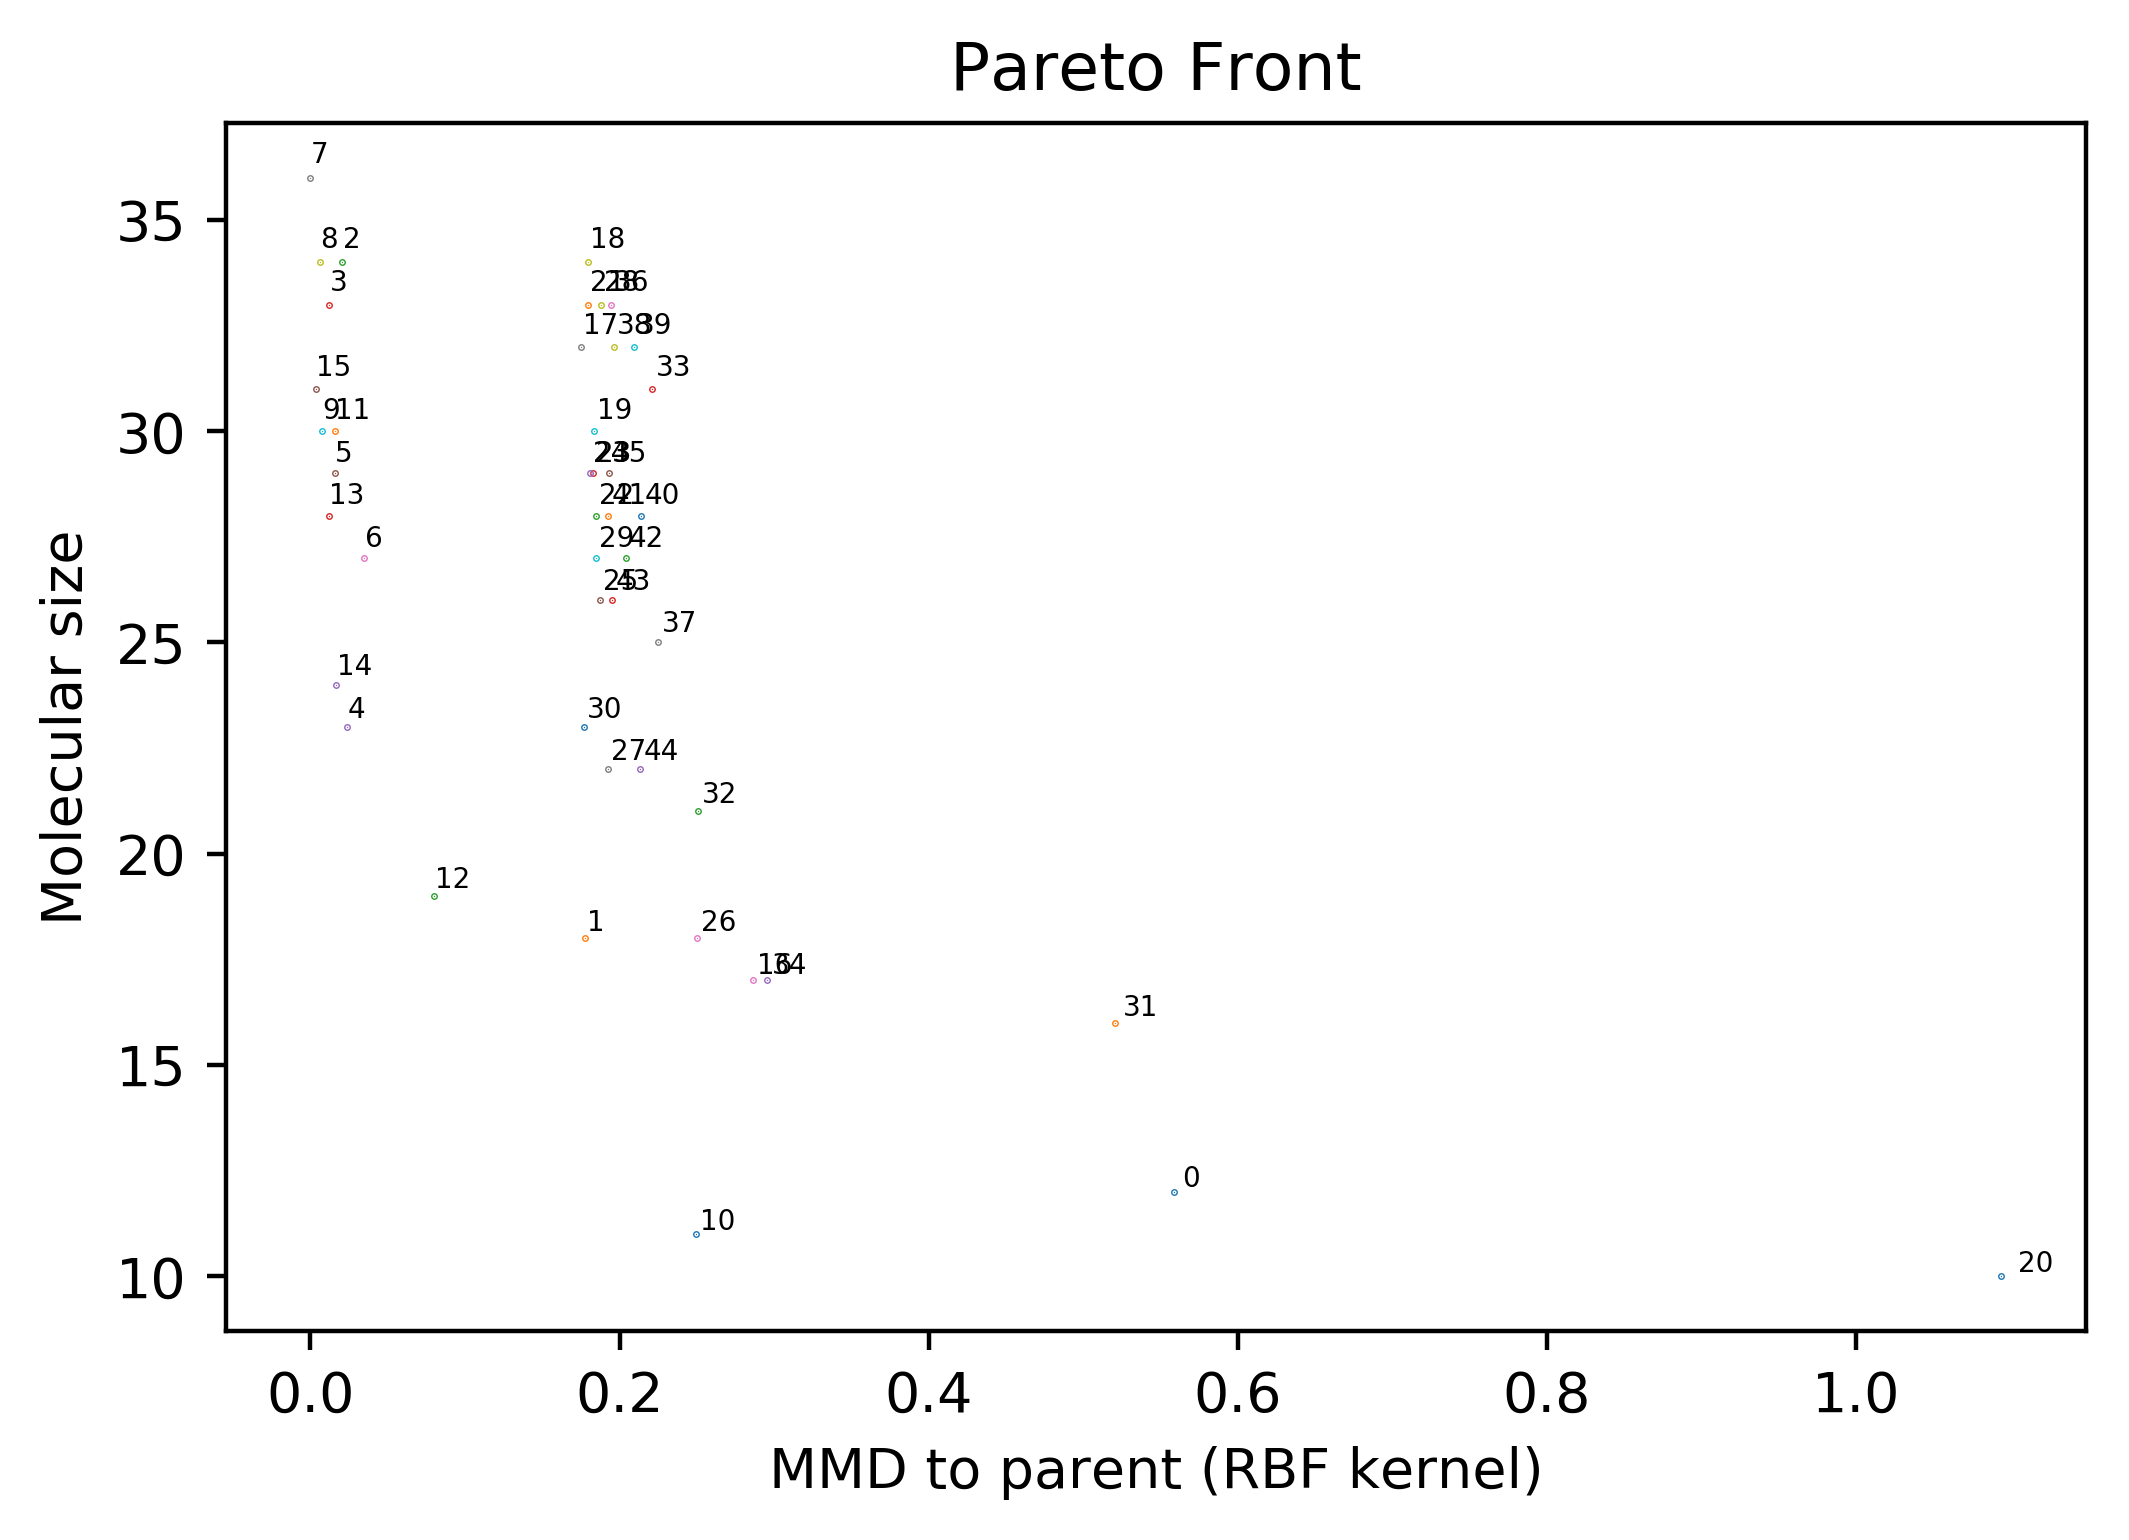

In [474]:

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)
#plt.plot(linear, heavy_atoms, 'o', label='linear')
#plt.plot(squared, heavy_atoms, 'o', label='quadradic')
for i in range(len(rbf)):
    x = rbf[i]
    y = heavy_atoms[i]
    plt.plot(x, y, '.', markersize=0.5)
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , frag_idx[i], fontsize=5)

#plt.plot(rbf, heavy_atoms, '.', label='radial basis function')
#plt.legend();
#plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
#for i, xy in enumerate(zip(heavy_atoms, rbf)):                      
#    ax.annotate('{}'.format(i), xy=xy)#, textcoords='data')
#plt.savefig('test.pdf')
#plt.close()
plt.title('Pareto Front')
plt.xlabel('MMD to parent (RBF kernel)')
plt.ylabel('Molecular size');

In [475]:
norm = plt.Normalize(min(rbf), max(rbf))
colors = plt.cm.viridis_r(norm(rbf)) 

In [478]:
colors

array([[0.131172, 0.555899, 0.552459, 1.      ],
       [0.575563, 0.844566, 0.256415, 1.      ],
       [0.9553  , 0.901065, 0.118128, 1.      ],
       [0.974417, 0.90359 , 0.130215, 1.      ],
       [0.945636, 0.899815, 0.112838, 1.      ],
       [0.964894, 0.902323, 0.123941, 1.      ],
       [0.916242, 0.896091, 0.100717, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.983868, 0.904867, 0.136897, 1.      ],
       [0.983868, 0.904867, 0.136897, 1.      ],
       [0.412913, 0.803041, 0.357269, 1.      ],
       [0.964894, 0.902323, 0.123941, 1.      ],
       [0.814576, 0.883393, 0.110347, 1.      ],
       [0.974417, 0.90359 , 0.130215, 1.      ],
       [0.964894, 0.902323, 0.123941, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.335885, 0.777018, 0.402049, 1.      ],
       [0.585678, 0.846661, 0.249897, 1.      ],
       [0.575563, 0.844566, 0.256415, 1.      ],
       [0.565498, 0.84243 , 0.262877, 1.      ],
       [0.267004, 0.

In [44]:
sorted_frag

{(35,
  14): {'sorted_frags': ['c1cc(c(c(c1)F)S(=O)(=O)N)F',
   'c1ccc(cc1)NS(=O)(=O)c2c(cccc2F)F',
   'CC(C)(C)c1nc(c(s1)c2ccnc(n2)N)c3cccc(c3)NS(=O)(=O)c4c(cccc4F)F',
   'CC(C)(C)c1nc(c(s1)c2ccncn2)c3cccc(c3)NS(=O)(=O)c4c(cccc4F)F',
   'c1cc(cc(c1)NS(=O)(=O)c2c(cccc2F)F)c3cscn3',
   'c1cc(cc(c1)NS(=O)(=O)c2c(cccc2F)F)c3c(scn3)c4ccncn4',
   'CC(C)(C)c1nc(cs1)c2cccc(c2)NS(=O)(=O)c3c(cccc3F)F',
   'parent',
   'CC(C)(C)c1nc(c(s1)c2ccncn2)c3cccc(c3F)NS(=O)(=O)c4c(cccc4F)F',
   'c1cc(c(c(c1)NS(=O)(=O)c2c(cccc2F)F)F)c3c(scn3)c4ccncn4',
   'c1ccc(c(c1)F)S(=O)(=O)N',
   'c1cc(cc(c1)NS(=O)(=O)c2c(cccc2F)F)c3c(scn3)c4ccnc(n4)N',
   'c1ccc(c(c1)NS(=O)(=O)c2c(cccc2F)F)F',
   'CC(C)(C)c1nc(cs1)c2cccc(c2F)NS(=O)(=O)c3c(cccc3F)F',
   'c1cc(c(c(c1)NS(=O)(=O)c2c(cccc2F)F)F)c3cscn3',
   'c1cc(c(c(c1)NS(=O)(=O)c2c(cccc2F)F)F)c3c(scn3)c4ccnc(n4)N',
   'c1ccc(cc1)NS(=O)(=O)c2ccccc2F',
   'CC(C)(C)c1nc(c(s1)c2ccncn2)c3cccc(c3)NS(=O)(=O)c4ccccc4F',
   'CC(C)(C)c1nc(c(s1)c2ccnc(n2)N)c3cccc(c3F)NS(=O)(=O)c4c